# Photovoltaics Interactive Tabletop Approach Experiments/Tests
Cristian Sorescu 879091

## Imports

In [48]:
import numpy as np
import pandas as pd
import tsfresh
import matplotlib.pyplot as plt
from sklearn import preprocessing
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Flatten, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import glob
import os
import itertools

## Helper Functions

In [348]:
# Lag Features generation, 
# predict the value at the next time (t+1) given the value at the previous time (t-1).
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

# definition of cnn model
def get_model(_shape, num_classes):
    # number of classes
    #nclass = 6
    
    inp = Input(shape=_shape)
    print(inp)
    
    # layers
    # kernel size as tuple
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(num_classes, activation=activations.softmax, name="dense_3")(dense_1)

    # model definition
    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy) # metrics=['accuracy']
    model.summary()
    
    return model

# extract filename from a given path
def path_to_fname(_path):
    return os.path.basename(os.path.splitext(_path)[0])

# remove digits and underscore _ from a given string
def rm_digit_undscore(_string):
    return ''.join(c for c in _string if not c.isdigit() and not c == '_')

# Confusion matrix plot function definition
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized confusion matrix"
    else:
        title = 'Confusion matrix'
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()

# load data from given file list    
def load_data(file_list):
    classes = []
    gestures = []
    
    for fp in file_list:
        gesture = pd.read_csv(fp, delim_whitespace=False, header=[0, 1], index_col=0)
        gesture = gesture.rolling(window = 100).mean()
        gesture = gesture.dropna()
        gestures.append(gesture.values)
        classes.append(rm_digit_undscore(path_to_fname(fp)))
    
    gestures = np.array(gestures)
    classes = np.array(classes)
    return classes, gestures

## Load Train Data

In [366]:
# files containing train data
path = "csv/train/*/"
train_files = glob.glob(path + '/*.csv')

# load train data
train_classes, train_data = load_data(train_files)
train_data = np.expand_dims(train_data, axis=1)
print(train_data.shape)

# encoded labels 
label_encoder = preprocessing.LabelEncoder()
enc_train_labels = label_encoder.fit_transform(train_classes)
print(enc_train_labels.shape)
print(np.unique(enc_train_labels))

print(np.unique(class_train))
print(label_encoder.inverse_transform([1]))

(116, 1, 14905, 1)
(116,)
[0 1 2 3 4 5]
['clockwise' 'counterclockwise' 'fistForm' 'raiseLower' 'swipe' 'swipes']
['counterclockwise']


In [112]:
# normalize the data, scale the y axis (valtage)
# min_max_scaler = preprocessing.MinMaxScaler()
# y_scaled = min_max_scaler.fit_transform(y_train)

# test plot
#plt.scatter(x_train, y_train, label = "Foo")
#plt.plot(x_train, y_scaled, label = "Bar")
#plt.legend(loc='best')
#plt.show()

## Load test data

In [375]:
test_files = glob.glob('csv/test/*.csv')
test_classes, test_data = load_data(test_files)
print(test_data.shape)

# encoded labels 
label_encoder = preprocessing.LabelEncoder()
enc_test_labels = label_encoder.fit_transform(test_classes)
print(enc_test_labels.shape)

(44, 14905, 1)
(44,)


## CNN

In [368]:
num_classes = len(np.unique(enc_train_labels))
cnn_model = get_model(train_data[0, 0, :].shape, num_classes)

Tensor("input_9:0", shape=(None, 14905, 1), dtype=float32)
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 14905, 1)          0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 14901, 16)         96        
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 14897, 16)         1296      
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 7448, 16)          0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 7448, 16)          0         
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 7446, 32)          1568      
_________________________________________________________________


In [369]:
# early = EarlyStopping(monitor="accuracy", mode="max", patience=5, verbose=1)
# redonplat = ReduceLROnPlateau(monitor="accuracy", mode="max", patience=3, verbose=2)
# callbacks_list = [early, redonplat]

# data for training
x_train = train_data[:,0,:]

# fit data into the cnn model, training
cnn_model.fit(x_train, enc_train_labels, epochs=150, verbose=1, batch_size=train_data[:,0,0,0].shape[0])

Epoch 1/150
116/116 [==============================] - 18s 154ms/step - loss: 1.7907
Epoch 2/150
116/116 [==============================] - 13s 109ms/step - loss: 1.7882
Epoch 3/150
116/116 [==============================] - 18s 158ms/step - loss: 1.7833
Epoch 4/150
116/116 [==============================] - 12s 105ms/step - loss: 1.7750
Epoch 5/150
116/116 [==============================] - 12s 107ms/step - loss: 1.7690
Epoch 6/150
116/116 [==============================] - 12s 100ms/step - loss: 1.7573
Epoch 7/150
116/116 [==============================] - 11s 98ms/step - loss: 1.7454
Epoch 8/150
116/116 [==============================] - 11s 91ms/step - loss: 1.7352
Epoch 9/150
116/116 [==============================] - 11s 93ms/step - loss: 1.7187
Epoch 10/150
116/116 [==============================] - 11s 92ms/step - loss: 1.6995
Epoch 11/150
116/116 [==============================] - 10s 89ms/step - loss: 1.6745
Epoch 12/150
116/116 [==============================] - 12s 102ms/st

Epoch 98/150
116/116 [==============================] - 10s 87ms/step - loss: 1.0192
Epoch 99/150
116/116 [==============================] - 10s 87ms/step - loss: 0.9918
Epoch 100/150
116/116 [==============================] - 10s 87ms/step - loss: 1.0009
Epoch 101/150
116/116 [==============================] - 10s 88ms/step - loss: 0.9362
Epoch 102/150
116/116 [==============================] - 10s 86ms/step - loss: 1.0177
Epoch 103/150
116/116 [==============================] - 10s 87ms/step - loss: 0.9343
Epoch 104/150
116/116 [==============================] - 10s 87ms/step - loss: 0.9478
Epoch 105/150
116/116 [==============================] - 10s 86ms/step - loss: 0.9402
Epoch 106/150
116/116 [==============================] - 10s 86ms/step - loss: 0.9491
Epoch 107/150
116/116 [==============================] - 10s 87ms/step - loss: 0.9238
Epoch 108/150
116/116 [==============================] - 10s 86ms/step - loss: 0.9680
Epoch 109/150
116/116 [==============================] -

In [376]:
cnn_pred = cnn_model.predict(test_data)
cnn_pred = np.argmax(cnn_pred, axis=-1)
cnn_pred = label_encoder.inverse_transform(cnn_pred)

print(np.unique(cnn_pred))

for i in range(len(cnn_pred)):
    print('predicted: ', cnn_pred[i], 'true: ', test_classes[i])

# f1 score, weighted average of the precision and recall, 
# f1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(test_classes, cnn_pred, average="macro")
print("\nTest f1 score : %s "% f1)

# accuracy score, set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
# accuracy score reaches its best value at 1 and worst score at 0.
acc = accuracy_score(test_classes, cnn_pred)
print("Test accuracy score : %s"% acc)

['clockwise' 'counterclockwise' 'fistForm' 'raiseLower' 'swipe' 'swipes']
predicted:  swipes true:  swipes
predicted:  swipes true:  swipes
predicted:  swipes true:  swipes
predicted:  counterclockwise true:  counterclockwise
predicted:  counterclockwise true:  swipe
predicted:  counterclockwise true:  swipe
predicted:  swipes true:  swipes
predicted:  raiseLower true:  raiseLower
predicted:  fistForm true:  fistForm
predicted:  raiseLower true:  raiseLower
predicted:  raiseLower true:  clockwise
predicted:  raiseLower true:  raiseLower
predicted:  raiseLower true:  raiseLower
predicted:  counterclockwise true:  clockwise
predicted:  fistForm true:  fistForm
predicted:  fistForm true:  fistForm
predicted:  raiseLower true:  raiseLower
predicted:  clockwise true:  clockwise
predicted:  clockwise true:  clockwise
predicted:  clockwise true:  clockwise
predicted:  fistForm true:  fistForm
predicted:  raiseLower true:  raiseLower
predicted:  clockwise true:  clockwise
predicted:  clockwise

### CNN Confusion matrix

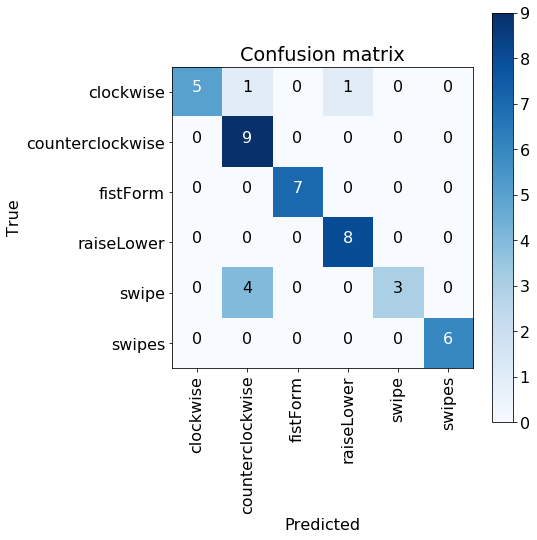

In [381]:
# compute confusion matrix
cnn_matrix = confusion_matrix(test_classes, cnn_pred)

# plot confusion matrix
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnn_matrix, np.unique(test_classes), title='CNN Confusion matrix')

## Random Forest

In [85]:
from sklearn.ensemble import RandomForestClassifier

In [246]:
# random forest model
parameters = {'bootstrap': True,
              'min_samples_leaf': 3,
              'n_estimators': 50, 
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 500,
              'max_leaf_nodes': None}

rf_model = RandomForestClassifier(**parameters)

In [247]:
# fit/train random forest model
rf_model.fit(train_data[:, 0, :, 0], train_classes)
print('train data shape: ', train_data[:, 0, :, 0].shape)

train data shape:  (100, 14905)


In [378]:
# apply random forest model on test data
print('test data shape: ', test_data[:,:,0].shape)
rf_pred = rf_model.predict(test_data[:,:,0])

# f1 score, weighted average of the precision and recall, 
# f1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(test_classes, rf_pred, average="macro")
print("Test f1 score : %s "% f1)

# accuracy score, set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
# accuracy score reaches its best value at 1 and worst score at 0.
acc = accuracy_score(test_classes, rf_pred)
print("Test accuracy score : %s"% acc)

test data shape:  (44, 14905)
Test f1 score : 0.743357595563478 
Test accuracy score : 0.75


### Random Forest Confusion matrix

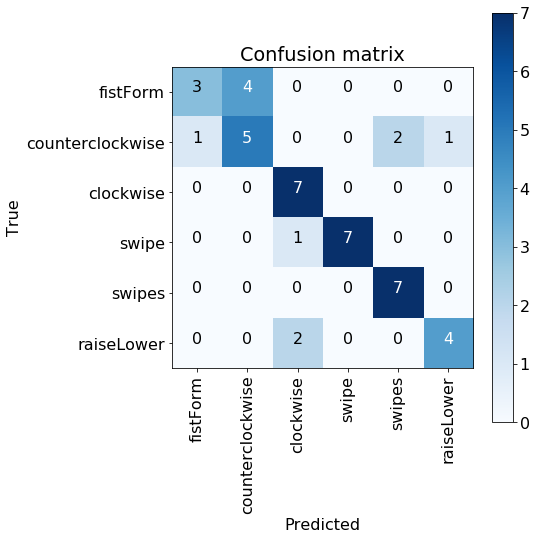

In [379]:
# compute confusion matrix
rf_matrix = confusion_matrix(test_classes, rf_pred)

# plot confusion matrix
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 8))
plot_confusion_matrix(rf_matrix, set(test_classes), title='Random Forest Confusion matrix')

## Plot Gestures

In [82]:
# read_csv parameters
csv_params = "delim_whitespace=False, header=[0, 1], index_col=0"

# gestures data
gestures = []

# fist formation gesture
handDetect = pd.read_csv('csv/hand_detected_1.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([handDetect, 'Hand Detetction'])
# fist formation gesture
fistForm = pd.read_csv('csv/train/fistForm_1.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([fistForm, 'Fist Formation'])
# clockwise motion gesture
clockwise = pd.read_csv('csv/train/clockwise_1.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([clockwise, 'Clockwise Motion'])
# counterclockwise motion gesture
counterclockwise = pd.read_csv('csv/train/counterclockwise_2.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([counterclockwise, 'Counterclockwise Motion'])
# continuous swipes motion gesture
swipe = pd.read_csv('csv/train/swipe_1.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([swipe, 'Singular Swipe'])
# singular swipe motion gesture
swipes = pd.read_csv('csv/train/swipes_1.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([swipes, 'Continuous Swipes'])
# raise and Lower hand motion
raiseLower = pd.read_csv('csv/train/raiseLower_1.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([raiseLower, 'Raise/Lower Hand Motion'])

# testing
gesture = fistForm

#gesture = series_to_supervised(gesture, 79)
print(gesture.shape)

(15004, 1)


In [10]:
# # rolling mean of gesture, reduce noise
# rollingMean_train = gesture.rolling(window = 100).mean()
# rollingMean_train = rollingMean_train.dropna().drop_duplicates()

# # define training data for gesture based on the rolling mean
# y_train = np.array(rollingMean_train.values).astype(np.double)[:,0]
# x_train = np.transpose(np.array(rollingMean_train.values))[..., np.newaxis]
# x_train = np.expand_dims(x_train, axis=0)

# # y_train = np.expand_dims(y_train, axis=-1)
# # print(y_train.shape)

# print(y_train.shape)
# print(x_train.shape)

(14834,)
(1, 1, 14834, 1)


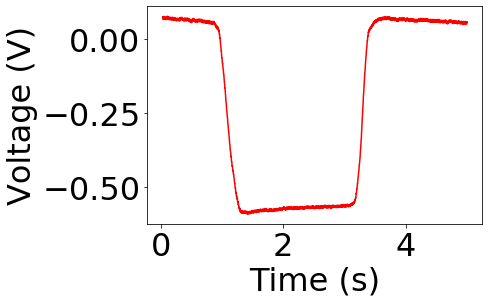

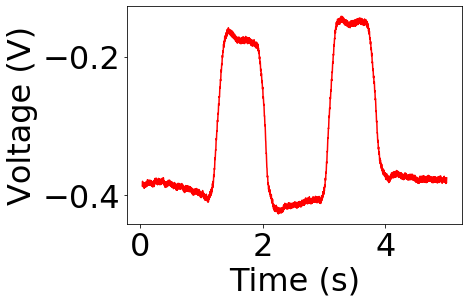

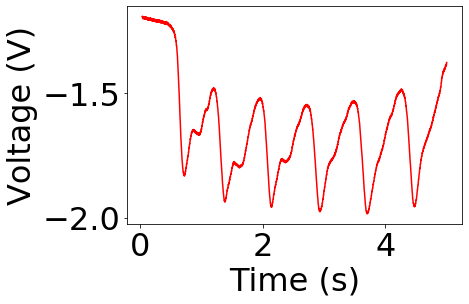

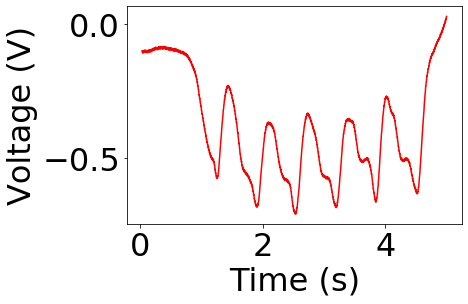

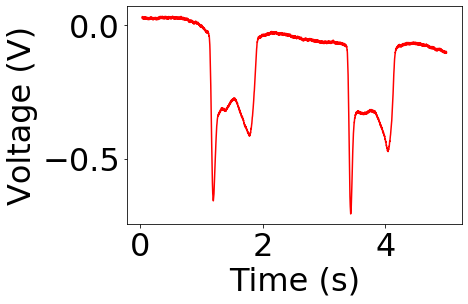

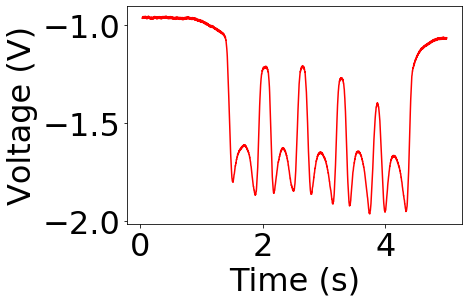

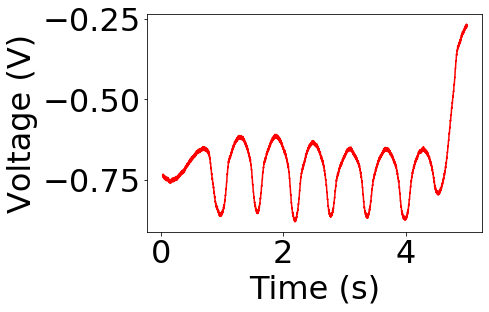

In [43]:
plt.rcParams.update({'font.size': 32})

for gesture in gestures:
    gestureDF, title = gesture
    #gestureDF.columns = gestureDF.columns.droplevel(1)
    plotTitle = title

    rollingMean = gestureDF.rolling(window = 100).mean()
    rollingMean = rollingMean.dropna().drop_duplicates()
    rollingStd = gestureDF.rolling(window = 12).std()
    #plt.plot(gestureDF, color = 'blue', label = 'Original')
    plt.plot(rollingMean, color = 'red', label = 'Rolling Mean')
    #plt.plot(rollingStd, color = 'black', label = 'Rolling STD')
    #plt.legend(loc = 'best', prop={'size': 13})
    #plt.title(plotTitle)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    #minR = round(gestureDF.min().to_numpy()[0], 1)
    #maxR = round(gestureDF.max().to_numpy()[0], 1)
    #plt.yticks(np.arange(minR, maxR, step=0.3)) 
    plt.show()

## Other stuff

In [23]:
# tests

# inp =  Input(shape=(5, 1))
# conv = Convolution1D(filters=2, kernel_size=2)(inp)
# pool = MaxPool1D(pool_size=2)(conv)
# flat = Flatten()(pool)
# dense = Dense(1)(flat)
# model = models.Model(inp, dense)
# model.compile(loss='mse', optimizer='adam')

# #print(model.summary())

# # get some data
# X = np.expand_dims(np.random.randn(10, 5), axis=2)
# y = np.random.randn(10, 1)

# print(X.shape)
# print(y.shape)

# # fit model
# model.fit(X, y)

In [ ]:
# plot the data

#fistForm.shape
#fistForm.head(3)
gestures[:5]

#handDetect['Channel A'].plot(linewidth=1);
#fistForm['Channel A'].plot(linewidth=1);
#clockwise['Channel A'].plot(linewidth=1);

# tsfresh Tests

In [ ]:
# extract features
fistForm.reset_index(inplace=True)
fistForm_features = tsfresh.extract_features(fistForm, column_id='index', n_jobs=4)

#fistForm_features = tsfresh.extract_features(fistForm)

#clockwise_features = tsfresh.extract_features(clockwise)

#counterclockwise_features = tsfresh.extract_features(counterclockwise)

#swipes_features = tsfresh.extract_features(swipes)

#swipe_features = tsfresh.extract_features(swipe)

#raiseLower_features = tsfresh.extract_features(raiseLower)

In [ ]:
from tsfresh.utilities.dataframe_functions import impute

impute(handDetect_features)

In [ ]:
#handDetect_features.head()
#handDetect.resample('3T').sum()
#handDetect.describe()

In [19]:
for gesture in gestures:
    gestureDF, title = gesture
    print(round(gestureDF.max().to_numpy()[0], 1))

0.1
-0.1
-1.1
0.1
0.1
-0.9
-0.2


In [ ]:
# tests

# import mass_ts as mts

# ts = handDetect3.to_numpy()
# q = handDetect.to_numpy()

# print(handDetect3[:,0])

# # mass
# distances = mts.mass(ts[:,0], q[:,0])

# # mass2
# distances = mts.mass2(ts[:,0], q[:,0])

# # mass3
# #distances = mts.mass3(ts[:,0], q[:,0], 256)

# # mass2_batch
# # start a multi-threaded batch job with all cpu cores and give me the top 5 matches.
# # note that batch_size partitions your time series into a subsequence similarity search.
# # even for large time series in single threaded mode, this is much more memory efficient than
# # MASS2 on its own.
# batch_size = 10000
# top_matches = 5
# n_jobs = 3
# indices, distances = mts.mass2_batch(ts[:,0], q[:,0], batch_size, 
#     top_matches=top_matches, n_jobs=n_jobs)

# # find minimum distance
# min_idx = np.argmin(distances)

# # find top 4 motif starting indices
# k = 4
# exclusion_zone = 25
# top_motifs = mts.top_k_motifs(distances, k, exclusion_zone)

# # find top 4 discord starting indices
# k = 4
# exclusion_zone = 25
# top_discords = mts.top_k_discords(distances, k, exclusion_zone)

# Wavelet analysis

In [12]:
import pywt
x = fistForm.values
# Discrete Wavelet Transform
#cA, cD = pywt.dwt(x, 'db2')
#x2 = pywt.idwt(cA, cD, 'db2')
x

array([[-0.4464858],
       [-0.4400769],
       [-0.4477065],
       ...,
       [-0.3476058],
       [-0.3524888],
       [-0.3497421]])

In [16]:
# for mode_name in ['zero', 'constant', 'symmetric', 'reflect', 'periodic', 'smooth', 'periodization']:
#     mode = getattr(pywt.Modes, mode_name)
#     cA, cD = pywt.dwt(x, 'db2', mode)
#     print("Mode: %d (%s)" % (mode, mode_name))

Mode: 0 (zero)
Mode: 2 (constant)
Mode: 1 (symmetric)
Mode: 6 (reflect)
Mode: 4 (periodic)
Mode: 3 (smooth)
Mode: 5 (periodization)


In [13]:
wp = pywt.WaveletPacket2D(data=x, wavelet='db1')

In [14]:
wp.data

array([[-0.4464858],
       [-0.4400769],
       [-0.4477065],
       ...,
       [-0.3476058],
       [-0.3524888],
       [-0.3497421]])

In [17]:
wp.data.shape

(15004, 1)

In [ ]:
wp['a'].data